<a href="https://colab.research.google.com/github/turdutra/Jogo-Online/blob/main/Steerability_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as kr
from tensorflow.keras import layers, activations, initializers, Input
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.python.framework import tensor_shape
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import balanced_accuracy_score
import random
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
import pickle
import shutil
from google.colab import files



In [28]:
!pip install keras-tuner
import keras_tuner as kt
from tensorflow.keras.models import Sequential

In [29]:
seed_value = 42  # Set your seed value here

# Setting the seed for Python's built-in random module
random.seed(seed_value)

# Setting the seed for NumPy
np.random.seed(seed_value)

# Setting the seed for TensorFlow
tf.random.set_seed(seed_value)

# Processing the dataset

In [30]:
import pickle

# Path to your pickle file
file_path = '/content/ML_dataset_chau.pkl'

# Load the contents of the pickle file
with open(file_path, 'rb') as file:
    df = pickle.load(file)

print(len(df))

df.head()

32110


,State,Inner Radius,Outer Radius
0,"[[(0.11415758+6.52071404e-18j), (1.42405004+0....",0.976827,1.011942
1,"[[(0.04248165-1.1291822e-18j), (1.306768-1.108...",0.581072,0.601960
2,"[[(0.28903962+5.61944632e-18j), (0.19896354-0....",0.105408,0.109197
3,"[[(0.20113779-9.26598317e-18j), (0.10041543+0....",1.106568,1.146346
4,"[[(0.02526758-5.15315723e-19j), (0.46029251-0....",0.696296,0.721326


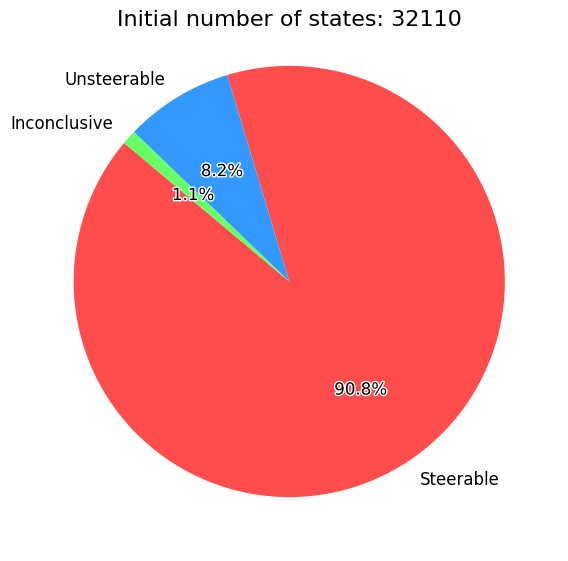

In [31]:
# Define the function to apply the conditions
def set_local(row):
    if row['Inner Radius'] > 1:
        return True
    elif row['Outer Radius'] < 1:
        return False
    else:
        return np.nan

# Function to add black outline to text
def outline_text(text, ax, lw=3):
    for txt in text:
        txt.set_path_effects([plt.Line2D(1, 0), plt.PathEffectStroke(linewidth=lw, foreground='white'), plt.PathEffectNormal()])

# Apply the function to each row
df['Local'] = df.apply(set_local, axis=1)


# Count the occurrences of each state
count_unsteerable = df['Local'].fillna('Inconclusive').value_counts()

# Labels and values for the pie chart
labels = ['Unsteerable' if x == True else 'Steerable' if x == False else 'Inconclusive' for x in count_unsteerable.index]
sizes = count_unsteerable.values
total_entries = len(df)

# Colors for the slices
colors = ['#ff4d4d', '#3399ff', '#66ff66']


# Create a pie chart
fig, ax = plt.subplots(figsize=(10, 7))

# Draw the pie chart
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 12})

# Add the total number of entries at the top
plt.title(f'Initial number of states: {total_entries}', y=0.96, fontsize=16)


# Improve the legend
for text in autotexts:
    text.set_color('black')
    text.set_fontsize(12)
    text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='white'), path_effects.Normal()])


# Show the plot
plt.show()




In [32]:
# Drop rows with NaN in the "Local" column
df = df.dropna(subset=['Local'])

print(len(df))
# Display the updated dataframe
df.head()

# Shuffle the DataFrame
df = df.sample(frac=1).reset_index(drop=True)

# Define the train-test split fraction
train_fraction = 0.9
train_size = int(len(df) * train_fraction)

# Split the DataFrame
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()


31762


In [33]:

print(train_df['Local'].value_counts())


# Separate the DataFrame into two based on the 'local' value
df_false = train_df[train_df['Local'] == False]
df_true = train_df[train_df['Local'] == True]

# Find the number to downsample to (the size of the smaller class)
n_samples = min(len(df_false), len(df_true))

# Downsample both DataFrames
df_false_downsampled = df_false.sample(n=n_samples)
df_true_downsampled = df_true.sample(n=n_samples)

# Concatenate the downsampled DataFrames back into one balanced DataFrame
train_df_balanced = pd.concat([df_false_downsampled, df_true_downsampled])

print(train_df_balanced['Local'].value_counts())

Local
False    26227
True      2358
Name: count, dtype: int64
Local
False    2358
True     2358
Name: count, dtype: int64


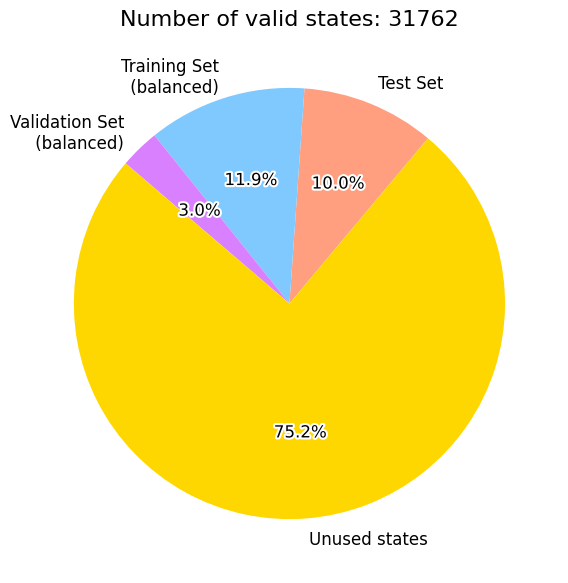

In [38]:
# Define the proportions
test_set = 0.10
training_set = 0.90
actual_training_set = training_set * (len(train_df_balanced)/len(train_df))
validation_set = actual_training_set * 0.20

# Calculate remaining training set after taking out validation
remaining_training_set = actual_training_set - validation_set

# Proportions for the pie chart
proportions = [test_set, remaining_training_set, validation_set, training_set - actual_training_set]
labels = ['Test Set', f'Training Set\n (balanced)', f'Validation Set\n (balanced)', 'Unused states']

# Function to format the text with a white outline
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return f'{pct:.1f}%'
    return my_autopct

# Create the pie chart
fig, ax = plt.subplots(figsize=(10, 7))
colors = ['#ff9f80', '#80c9ff', '#d980ff', '#ffd700']
wedges, texts, autotexts = ax.pie(proportions, labels=labels, autopct=make_autopct(proportions), startangle=50, colors=colors, textprops={'fontsize': 12})
plt.title(f'Number of valid states: {len(df)}', y=1, fontsize=16)

# Add a white outline to the percentage text
for autotext in autotexts:
    autotext.set_fontsize(12)
    autotext.set_color('black')
    autotext.set_path_effects([path_effects.withStroke(linewidth=3, foreground='white')])

plt.show()


In [39]:
# manipulate the data to fit the input and output of the training

def one_hot_encoding(bool):
  if bool:
    return np.array([1,0])
  else:
    return np.array([0,1])


# Function to separate real and imaginary parts
def split_complex(arr):
    # Shape of the original array should be (4, 4, 1)
    real_part = np.real(arr)  # Extract real parts
    imag_part = np.imag(arr)  # Extract imaginary parts
    # Stack them along the last axis to make (4, 4, 2)
    return np.stack((real_part, imag_part), axis=-1)


def pauli_coefficients(matrix):
    if matrix.shape != (4, 4):
        raise ValueError("Input matrix must be 4x4")

    # Define Pauli matrices
    I = np.array([[1, 0], [0, 1]], dtype=complex)
    X = np.array([[0, 1], [1, 0]], dtype=complex)
    Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    Z = np.array([[1, 0], [0, -1]], dtype=complex)

    # List of Pauli basis matrices, excluding I ⊗ I
    pauli_basis = [
        np.kron(p1, p2)
        for p1 in [I, X, Y, Z]
        for p2 in [I, X, Y, Z]
        if not (np.array_equal(p1, I) and np.array_equal(p2, I))
    ]

    coefficients = np.zeros(15)  # 16 - 1 = 15 basis matrices
    for i, pauli_matrix in enumerate(pauli_basis):
        coefficients[i] = (np.trace(np.dot(pauli_matrix.conj().T, matrix)) / 4.0).real

    return coefficients

def split_hyper_complex(arr):
    # Shape of the original array should be (4, 4, 1)
    real_part = np.real(arr)  # Extract real parts
    imag_part = np.imag(arr)  # Extract imaginary parts
    # Create zero arrays with the same shape
    zero_part1 = np.zeros_like(real_part)
    zero_part2 = np.zeros_like(real_part)
    # Stack them along the last axis to make (4, 4, 4)
    return np.stack((real_part, imag_part, zero_part1, zero_part2), axis=-1)




# Apply the function to the DataFrame
train_df_balanced['Local'] = train_df_balanced['Local'].apply(one_hot_encoding)
train_df_balanced['State Complex'] = train_df_balanced['State'].apply(split_complex)
train_df_balanced['State Real'] = train_df_balanced['State'].apply(pauli_coefficients)
train_df_balanced['State Quat'] = train_df_balanced['State'].apply(split_hyper_complex)


train_df_balanced.head()

,State,Inner Radius,Outer Radius,Local,State Complex,State Real,State Quat
28159,"[[(0.06546371+9.26254675e-18j), (0.0532779+0.0...",0.286289,0.296581,"[0, 1]","[[[0.06546371, 9.26254675e-18], [0.0532779, 0....","[0.0745973, -0.02667287905, -0.20882413, 0.051...","[[[0.06546371, 9.26254675e-18, 0.0, 0.0], [0.0..."
20108,"[[(0.22255363-5.1124061e-18j), (0.19025568+0.0...",0.091947,0.095252,"[0, 1]","[[[0.22255363, -5.1124061e-18], [0.19025568, 0...","[0.18468834, -0.14736088619999999, -0.01132188...","[[[0.22255363, -5.1124061e-18, 0.0, 0.0], [0.1..."
3053,"[[(0.06164871+1.07546022e-18j), (0.12562705-0....",0.264066,0.273558,"[0, 1]","[[[0.06164871, 1.07546022e-18], [0.12562705, -...","[0.09088658999999999, 0.04940744275, -0.121150...","[[[0.06164871, 1.07546022e-18, 0.0, 0.0], [0.1..."
14703,"[[(0.31671973+1.1372957e-17j), (0.93334034+0.1...",0.596807,0.618260,"[0, 1]","[[[0.31671973, 1.1372957e-17], [0.93334034, 0....","[0.99304168, -0.2348171135, 0.0265396349999999...","[[[0.31671973, 1.1372957e-17, 0.0, 0.0], [0.93..."
23749,"[[(0.17366137+3.78508876e-18j), (0.21752164+0....",0.596151,0.617581,"[0, 1]","[[[0.17366137, 3.78508876e-18], [0.21752164, 0...","[0.907058865, 0.110949099, 0.05400797499999999...","[[[0.17366137, 3.78508876e-18, 0.0, 0.0], [0.2..."


In [40]:
# Apply the functions using .loc to avoid the SettingWithCopyWarning
test_df['Local'] = test_df['Local'].apply(one_hot_encoding)
test_df['State Complex'] = test_df['State'].apply(split_complex)
test_df['State Real'] = test_df['State'].apply(pauli_coefficients)
test_df['State Quat'] = test_df['State'].apply(split_hyper_complex)

# Display the head of the DataFrame
test_df.head()


,State,Inner Radius,Outer Radius,Local,State Complex,State Real,State Quat
28585,"[[(0.74754736+2.26014446e-17j), (0.03845578+0....",0.025323,0.026233,"[0, 1]","[[[0.74754736, 2.26014446e-17], [0.03845578, 0...","[0.043754555, -0.02811046303, 0.23679538, 0.09...","[[[0.74754736, 2.26014446e-17, 0.0, 0.0], [0.0..."
28586,"[[(0.35481685+1.79269914e-17j), (0.02729894-0....",0.244236,0.253016,"[0, 1]","[[[0.35481685, 1.79269914e-17], [0.02729894, -...","[0.03806466, 0.01102005476, 0.100512505, 0.120...","[[[0.35481685, 1.79269914e-17, 0.0, 0.0], [0.0..."
28587,"[[(0.16654255-9.74571958e-18j), (0.01650366+0....",1.488323,1.541825,"[1, 0]","[[[0.16654255, -9.74571958e-18], [0.01650366, ...","[0.06841122499999999, 0.015683981149999998, -0...","[[[0.16654255, -9.74571958e-18, 0.0, 0.0], [0...."
28588,"[[(0.5580962-7.34189942e-18j), (0.11046187+0.0...",0.175514,0.181824,"[0, 1]","[[[0.5580962, -7.34189942e-18], [0.11046187, 0...","[0.17743318, -0.0719209693, 0.0402926950000000...","[[[0.5580962, -7.34189942e-18, 0.0, 0.0], [0.1..."
28589,"[[(0.01537307-6.32532611e-19j), (0.20864646-0....",0.064570,0.066891,"[0, 1]","[[[0.01537307, -6.32532611e-19], [0.20864646, ...","[0.24573443, 0.054520727549999995, 0.074636315...","[[[0.01537307, -6.32532611e-19, 0.0, 0.0], [0...."


In [41]:
#Creating the step-decay learning rate
from keras.callbacks import LearningRateScheduler
def step_decay(epoch, lr):
    drop = 0.7
    epochs_drop = 10.0
    initial_lr = 0.001
    lr = initial_lr * (drop ** ((1 + epoch) / epochs_drop))
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

# Real dense network

This is the imput of the real networks

In [42]:
x_train_R= np.stack(train_df_balanced["State Real"].values, axis=0)
y_train_R=np.stack(train_df_balanced["Local"].values, axis=0)
x_test_R= np.stack(test_df["State Real"].values, axis=0)
y_test_R=np.stack(test_df["Local"].values, axis=0)

First we use keras tuner to get the optimal hyper-parameters

In [43]:
def build_model_R(hp):
    model = Sequential()
    model.add(Input(shape=(15,)))

    # Tune the number of units in the first Dense layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=512, step=10)
    model.add(Dense(units=hp_units_1, activation='relu'))

    # Tune the dropout rate in the first Dropout layer
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tune the number of units in the second Dense layer
    hp_units_2 = hp.Int('units_2', min_value=1, max_value=256, step=10)
    model.add(Dense(units=hp_units_2, activation='relu'))



    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
tuner_R = kt.RandomSearch(
    build_model_R,
    objective='val_accuracy',
    max_trials=400,
    executions_per_trial=2,
    directory='my_dir',
    project_name='real_model',
    overwrite=True
)
tuner_R.search(x_train_R, y_train_R, epochs=20, validation_split=0.2)

# Zip the folder (change 'my_folder' to your folder's name)
shutil.make_archive('/content/my_dir_R', 'zip', '/content/my_dir')

# Download the zipped folder
files.download('/content/my_dir_R.zip')

# Retrieve the best model
best_model_R = tuner_R.get_best_models(num_models=1)[0]
best_model_R.summary()

Now we implement the optimized model and train it

In [47]:
model_R = kr.Sequential([
    Input(shape=(15,)),
    Dense(492,activation='relu'),
    Dropout(0.3),
    Dense(231,activation='relu'),
    Dense(2,activation='softmax')
])

# Compile the model with accuracy metric
model_R.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_R.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 492)               7872      
                                                                 
 dropout_1 (Dropout)         (None, 492)               0         
                                                                 
 dense_4 (Dense)             (None, 231)               113883    
                                                                 
 dense_5 (Dense)             (None, 2)                 464       
                                                                 
Total params: 122219 (477.42 KB)
Trainable params: 122219 (477.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [48]:
# Fit the model
hist_R = model_R.fit(x_train_R, y_train_R, epochs=100,batch_size=32, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/100
118/118 [==============================] - 2s 9ms/step - loss: 0.5412 - accuracy: 0.6983 - val_loss: 0.5034 - val_accuracy: 0.6970 - lr: 9.6496e-04
Epoch 2/100
118/118 [==============================] - 1s 7ms/step - loss: 0.3868 - accuracy: 0.8210 - val_loss: 0.4249 - val_accuracy: 0.8114 - lr: 9.3115e-04
Epoch 3/100
118/118 [==============================] - 1s 6ms/step - loss: 0.2971 - accuracy: 0.8775 - val_loss: 0.3690 - val_accuracy: 0.8464 - lr: 8.9852e-04
Epoch 4/100
118/118 [==============================] - 2s 14ms/step - loss: 0.2612 - accuracy: 0.9011 - val_loss: 0.4121 - val_accuracy: 0.8358 - lr: 8.6704e-04
Epoch 5/100
118/118 [==============================] - 2s 18ms/step - loss: 0.2367 - accuracy: 0.9054 - val_loss: 0.3188 - val_accuracy: 0.8708 - lr: 8.3666e-04
Epoch 6/100
118/118 [==============================] - 1s 10ms/step - loss: 0.2125 - accuracy: 0.9075 - val_loss: 0.2806 - val_accuracy: 0.8972 - lr: 8.0734e-04
Epoch 7/100
118/118 [================

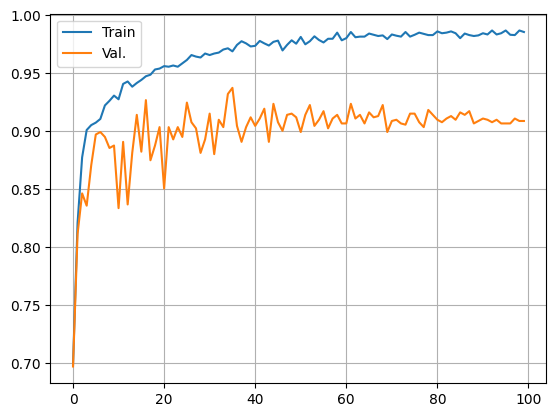

In [49]:
plt.plot(hist_R.history['accuracy'],label='Train')
plt.plot(hist_R.history['val_accuracy'],label='Val.')
plt.legend()
plt.grid()

# Complex convolutional network


First we define the custom layers

In [50]:
class ComplexDense(layers.Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros'
                ):
        super(ComplexDense, self).__init__()
        self.units = int(units) if not isinstance(units, int) else units
        self.activation = kr.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = kr.initializers.get(kernel_initializer)
        self.bias_initializer = kr.initializers.get(bias_initializer)

    def build(self, input_shape):
        assert input_shape[-1] % 2 == 0
        input_dim = input_shape[-1] // 2

        # Real-part of the weights
        self.kernel_r = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )
        # Imaginary-part of the weights
        self.kernel_i = self.add_weight(
            shape=(input_dim, self.units),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(2*self.units,), initializer="zeros", trainable=True
                )
        else:
            self.bias = None

    def call(self, inputs):
        W_r = tf.concat([self.kernel_r,-self.kernel_i],axis=0)
        W_i = tf.concat([self.kernel_i,self.kernel_r],axis=0)
        W = tf.concat([W_r,W_i],axis=1)
        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [51]:
class ComplexConv(layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None
                ):
        super(ComplexConv, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)
        self.initializer = kr.initializers.get(initializer)
        self.data_format = data_format

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('ComplexConv is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % 2 != 0:
            raise ValueError('The number of input channels must be divisible by 2.')

        input_dim = input_channel // 2
        kernel_shape = self.kernel_size + (input_dim, self.filters)

        self.kernel_r = self.add_weight(
            name='real_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )
        self.kernel_i = self.add_weight(
            name='imag_i_kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(2*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):
        # Filter multiplied from the right!
        F_r = tf.concat([self.kernel_r,-self.kernel_i],axis=2)
        F_i = tf.concat([self.kernel_i,self.kernel_r],axis=2)

        y_r = tf.nn.conv2d(inputs, F_r, strides=self.strides, padding=self.padding)
        y_i = tf.nn.conv2d(inputs, F_i, strides=self.strides, padding=self.padding)

        outputs = tf.concat([y_r, y_i],axis=3)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

This is their input

In [52]:
x_train_C= np.stack(train_df_balanced["State Complex"].values, axis=0)
y_train_C=np.stack(train_df_balanced["Local"].values, axis=0)
x_test_C= np.stack(test_df["State Complex"].values, axis=0)
y_test_C=np.stack(test_df["Local"].values, axis=0)

Now we tune the hyper-parameters

In [53]:
def build_model_C(hp):

    model = Sequential()

    model.add(layers.Input(shape=(4, 4, 2)))
    model.add(layers.Conv2D(filters=hp.Int('filters_1', min_value=4, max_value=128, step=10), kernel_size=(3, 3), activation='relu', padding='SAME'))
    model.add(layers.Dropout(hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(layers.Conv2D(filters=hp.Int('filters_2', min_value=4, max_value=128, step=10), kernel_size=(2, 2), activation='relu', padding='SAME'))
    model.add(layers.Flatten())
    model.add(layers.Dense(2, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
tuner_C = kt.RandomSearch(
    build_model_C,
    objective='val_accuracy',
    max_trials=400,
    executions_per_trial=2,
    directory='my_dir',
    project_name='complex_model'
)
tuner_C.search(x_train_C, y_train_C, epochs=20, validation_split=0.2, batch_size=32)

# Zip the folder (change 'my_folder' to your folder's name)
shutil.make_archive('/content/my_dir_C', 'zip', '/content/my_dir')

# Download the zipped folder
files.download('/content/my_dir_C.zip')

# Retrieve the best model
best_model_C = tuner_C.get_best_models(num_models=1)[0]
best_model_C.summary()

Now we implement and train the optimal model

In [69]:


model_C = kr.Sequential(
    [
        Input(shape=(4,4,2)),
        ComplexConv(84, kernel_size=(3, 3), activation="relu", padding='SAME'),
        Dropout(0.3),
        ComplexConv(114, kernel_size=(2, 2), activation="relu", padding='SAME'),
        Flatten(),
        ComplexDense(1, activation="softmax"),
    ]
)

model_C.summary()

model_C.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 complex_conv (ComplexConv)  (None, 4, 4, 168)         1680      
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 168)         0         
                                                                 
 complex_conv_1 (ComplexCon  (None, 4, 4, 228)         76836     
 v)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 3648)              0         
                                                                 
 complex_dense (ComplexDens  (None, 2)                 3650      
 e)                                                              
                                                                 
Total params: 82166 (320.96 KB)
Trainable params: 8216

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [56]:
hist_C = model_C.fit(x_train_C, y_train_C, batch_size=32, epochs=100, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/100
118/118 [==============================] - 5s 27ms/step - loss: 0.5111 - accuracy: 0.7227 - val_loss: 0.3993 - val_accuracy: 0.8369 - lr: 9.6496e-04
Epoch 2/100
118/118 [==============================] - 9s 76ms/step - loss: 0.3862 - accuracy: 0.8277 - val_loss: 0.4649 - val_accuracy: 0.7828 - lr: 9.3115e-04
Epoch 3/100
118/118 [==============================] - 7s 58ms/step - loss: 0.3267 - accuracy: 0.8632 - val_loss: 0.4189 - val_accuracy: 0.8167 - lr: 8.9852e-04
Epoch 4/100
118/118 [==============================] - 8s 68ms/step - loss: 0.2726 - accuracy: 0.8913 - val_loss: 0.3760 - val_accuracy: 0.8390 - lr: 8.6704e-04
Epoch 5/100
118/118 [==============================] - 5s 45ms/step - loss: 0.2497 - accuracy: 0.9001 - val_loss: 0.2812 - val_accuracy: 0.8919 - lr: 8.3666e-04
Epoch 6/100
118/118 [==============================] - 5s 44ms/step - loss: 0.2255 - accuracy: 0.9093 - val_loss: 0.3262 - val_accuracy: 0.8655 - lr: 8.0734e-04
Epoch 7/100
118/118 [=============

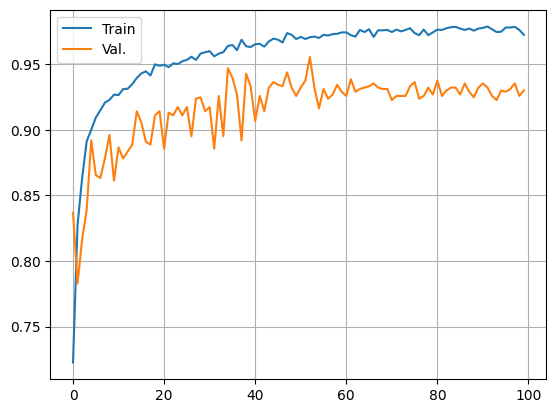

In [57]:
plt.plot(hist_C.history['accuracy'],label='Train')
plt.plot(hist_C.history['val_accuracy'],label='Val.')
plt.legend()
plt.grid()

# Quaternionic convolutional network



First we define the custom layers

In [58]:
quaternions = np.stack([np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,-1]]),
                        np.array([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,-1,0]]),
                        np.array([[0,0,1,0],[0,0,0,-1],[1,0,0,0],[0,1,0,0]]),
                        np.array([[0,0,0,1],[0,0,1,0],[0,-1,0,0],[1,0,0,0]])
                        ],axis=2)

In [59]:
class QuatDense(kr.layers.Layer):
    def __init__(self, units=32, use_bias=True, activation=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1)
                ):
        # Default complex numbers!
        super(QuatDense, self).__init__()
        self.algebra = np.float32(algebra)
        self.algdim = algebra.shape[2]
        self.units = units
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)  # Support specifying activation function

    def build(self, input_shape):
        assert input_shape[-1] % self.algdim == 0
        input_dim = input_shape[-1] // self.algdim

        # Real-part of the weights
        self.W = self.add_weight(
            shape=(input_dim, self.units,self.algdim),
            initializer="glorot_normal",
            trainable=True,
        )

        if self.use_bias:
            # Bias complex-valued
            self.b = self.add_weight(
                shape=(self.algdim * self.units,),
                initializer="zeros",
                trainable=True,
            )

    def call(self, inputs):
        W = tf.reduce_sum(
            [tf.experimental.numpy.kron(self.algebra[i,:,:],self.W[:,:,i]) for i in range(self.algdim)]
            ,axis=0)

        outputs = tf.matmul(inputs, W)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs, self.b)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

In [60]:
class QuatConv(kr.layers.Layer):
    def __init__(self,
                 filters,
                 kernel_size,
                 strides=1,
                 padding='VALID',
                 use_bias=True,
                 activation=None,
                 initializer='glorot_normal',
                 data_format=None,
                 algebra = np.stack([np.array([[1.0,0.0],[0.0,-1.0]]),np.array([[0.0,1.0],[1.0,0.0]])],axis=-1) # Complex Numbers
                ):
        super(QuatConv, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        self.use_bias = use_bias
        self.activation = kr.activations.get(activation)
        self.initializer = kr.initializers.get(initializer)
        self.data_format = data_format
        self.algebra = np.float32(algebra)
        self.alg_dim = algebra.shape[2]

    def _get_channel_axis(self):
        if self.data_format == 'channels_first':
            raise ValueError('QuatConv is designed only for channels_last. '
                             'The input must be changed to channels last!')
        else:
            return -1

    def _get_input_channel(self, input_shape):
        channel_axis = self._get_channel_axis()
        if input_shape.dims[channel_axis].value is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        return int(input_shape[channel_axis])

    def build(self, input_shape):
        input_shape = tensor_shape.TensorShape(input_shape)
        input_channel = self._get_input_channel(input_shape)
        if input_channel % self.alg_dim != 0:
            raise ValueError('The number of input channels must be divisible by %d.' % self.alg_dim)

        self.input_dim = input_channel // self.alg_dim
        kernel_shape = self.kernel_size + (self.input_dim, self.filters, self.alg_dim)

        self.kernel = self.add_weight(
            name='kernel',
            shape=kernel_shape,
            initializer=self.initializer,
            trainable=True,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                name='bias',
                shape=(self.alg_dim*self.filters,),
                initializer="zeros",
                trainable=True,
                dtype=self.dtype)
        else:
            self.bias = None

    def call(self, inputs):
        # Filter multiplied from the right!
        W = sum([tf.experimental.numpy.kron(self.algebra[k,:,:].reshape(1,1,self.alg_dim,self.alg_dim),self.kernel[:,:,:,:,k]) for k in range(self.alg_dim)])
        outputs = tf.nn.conv2d(inputs, W, strides=self.strides, padding=self.padding)

        if self.use_bias:
            outputs = tf.nn.bias_add(outputs,self.bias)

        if self.activation is not None:
            outputs = self.activation(outputs)

        return outputs

Then the imput of the layers

In [61]:
x_train_Q= np.stack(train_df_balanced["State Quat"].values, axis=0)
y_train_Q=np.stack(train_df_balanced["Local"].values, axis=0)
x_test_Q= np.stack(test_df["State Quat"].values, axis=0)
y_test_Q=np.stack(test_df["Local"].values, axis=0)


Now we tune the hyper-parameters

In [62]:
def build_model_Q(hp):
    model = Sequential()
    model.add(Input(shape=(4, 4, 4)))

    # Tune the number of filters in the first QuatConv layer
    hp_filters_1 = hp.Int('filters_1', min_value=4, max_value=90, step=5)
    model.add(QuatConv(filters=hp_filters_1, kernel_size=(3, 3), padding='SAME', activation='relu', algebra=quaternions))

    # Tune the dropout rate
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(rate=hp_dropout_1))

    # Tune the number of filters in the second QuatConv layer
    hp_filters_2 = hp.Int('filters_2', min_value=4, max_value=90, step=5)
    model.add(QuatConv(filters=hp_filters_2, kernel_size=(2, 2), padding='SAME', activation='relu', algebra=quaternions))



    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))

    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:

tuner_Q = kt.RandomSearch(
    build_model_Q,
    objective='val_accuracy',
    max_trials=50,
    executions_per_trial=2,
    directory='my_dir',
    project_name='quaternion_model'
)
tuner_Q.search(x_train_Q, y_train_Q, epochs=20, validation_split=0.2, batch_size=32)


# Zip the folder (change 'my_folder' to your folder's name)
shutil.make_archive('/content/my_dir_Q', 'zip', '/content/my_dir')

# Download the zipped folder
files.download('/content/my_dir_Q.zip')

best_model_Q = tuner_Q.get_best_models(num_models=1)[0]
best_model_Q.summary()


Fianlly we implement and train the optimal layer

In [64]:


model_Q = kr.Sequential([
    kr.Input(shape=(4,4,4)),
    QuatConv(84, (3,3), padding='SAME', activation='relu',algebra=quaternions),
    Dropout(0.5),
    QuatConv(79, (2,2), padding='SAME', activation='relu',algebra=quaternions),
    Flatten(),
    QuatDense(1, activation='softmax')])

# Checking the model summary
model_Q.summary()

model_Q.compile(optimizer='adam', loss=kr.losses.categorical_crossentropy, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quat_conv_2 (QuatConv)      (None, 4, 4, 336)         3360      
                                                                 
 dropout_1 (Dropout)         (None, 4, 4, 336)         0         
                                                                 
 quat_conv_3 (QuatConv)      (None, 4, 4, 316)         106492    
                                                                 
 flatten_1 (Flatten)         (None, 5056)              0         
                                                                 
 quat_dense (QuatDense)      (None, 2)                 5058      
                                                                 
Total params: 114910 (448.87 KB)
Trainable params: 114910 (448.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
hist_Q = model_Q.fit(x_train_Q, y_train_Q, batch_size=32, epochs=100, validation_split=0.2, callbacks=[lr_scheduler])

Epoch 1/100
118/118 [==============================] - 13s 88ms/step - loss: 0.5226 - accuracy: 0.7147 - val_loss: 0.3972 - val_accuracy: 0.8432 - lr: 9.6496e-04
Epoch 2/100
118/118 [==============================] - 11s 95ms/step - loss: 0.3951 - accuracy: 0.8057 - val_loss: 0.4530 - val_accuracy: 0.7860 - lr: 9.3115e-04
Epoch 3/100
118/118 [==============================] - 11s 90ms/step - loss: 0.3388 - accuracy: 0.8537 - val_loss: 0.4181 - val_accuracy: 0.8104 - lr: 8.9852e-04
Epoch 4/100
118/118 [==============================] - 10s 82ms/step - loss: 0.2786 - accuracy: 0.8900 - val_loss: 0.3525 - val_accuracy: 0.8528 - lr: 8.6704e-04
Epoch 5/100
118/118 [==============================] - 11s 92ms/step - loss: 0.2635 - accuracy: 0.8860 - val_loss: 0.2427 - val_accuracy: 0.9153 - lr: 8.3666e-04
Epoch 6/100
118/118 [==============================] - 12s 98ms/step - loss: 0.2364 - accuracy: 0.9056 - val_loss: 0.3241 - val_accuracy: 0.8612 - lr: 8.0734e-04
Epoch 7/100
118/118 [=======

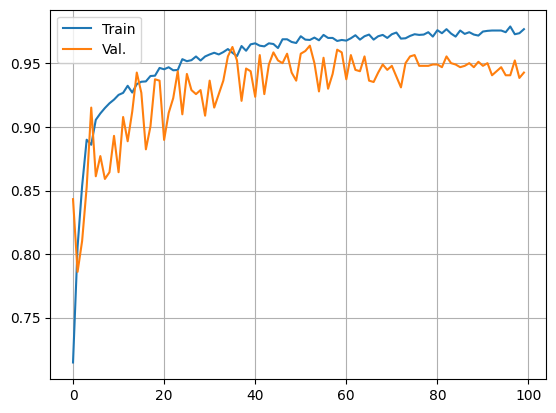

In [66]:
plt.plot(hist_Q.history['accuracy'],label='Train')
plt.plot(hist_Q.history['val_accuracy'],label='Val.')
plt.legend()
plt.grid()

# Comparison Real x Complex x Quaternionic

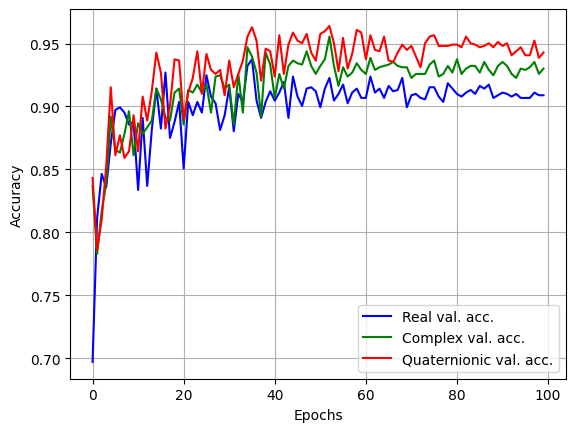

In [67]:
# Define colors for each model and their training/validation sets
colors = {
    'Real Train': 'lightblue',
    'Real Val.': 'blue',
    'Complex Train': 'lightgreen',
    'Complex Val.': 'green',
    'Quaternion Train': 'lightcoral',
    'Quaternion Val.': 'red'
}
font_size = 16  # Font size for axis labels

# Plot accuracy for Model R (Real)
#plt.plot(hist_R.history['accuracy'], label='Real Train', color=colors['Real Train'])
plt.plot(hist_R.history['val_accuracy'], label='Real val. acc.', color=colors['Real Val.'])

# Plot accuracy for Model C (Complex)
#plt.plot(hist_C.history['accuracy'], label='Complex Train', color=colors['Complex Train'])
plt.plot(hist_C.history['val_accuracy'], label='Complex val. acc.', color=colors['Complex Val.'])

# Plot accuracy for Model Q (Quaternion)
#plt.plot(hist_Q.history['accuracy'], label='Quaternion Train', color=colors['Quaternion Train'])
plt.plot(hist_Q.history['val_accuracy'], label='Quaternionic val. acc.', color=colors['Quaternion Val.'])

# Add legend, grid and show plot
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

100/100 [==============================] - 2s 18ms/step


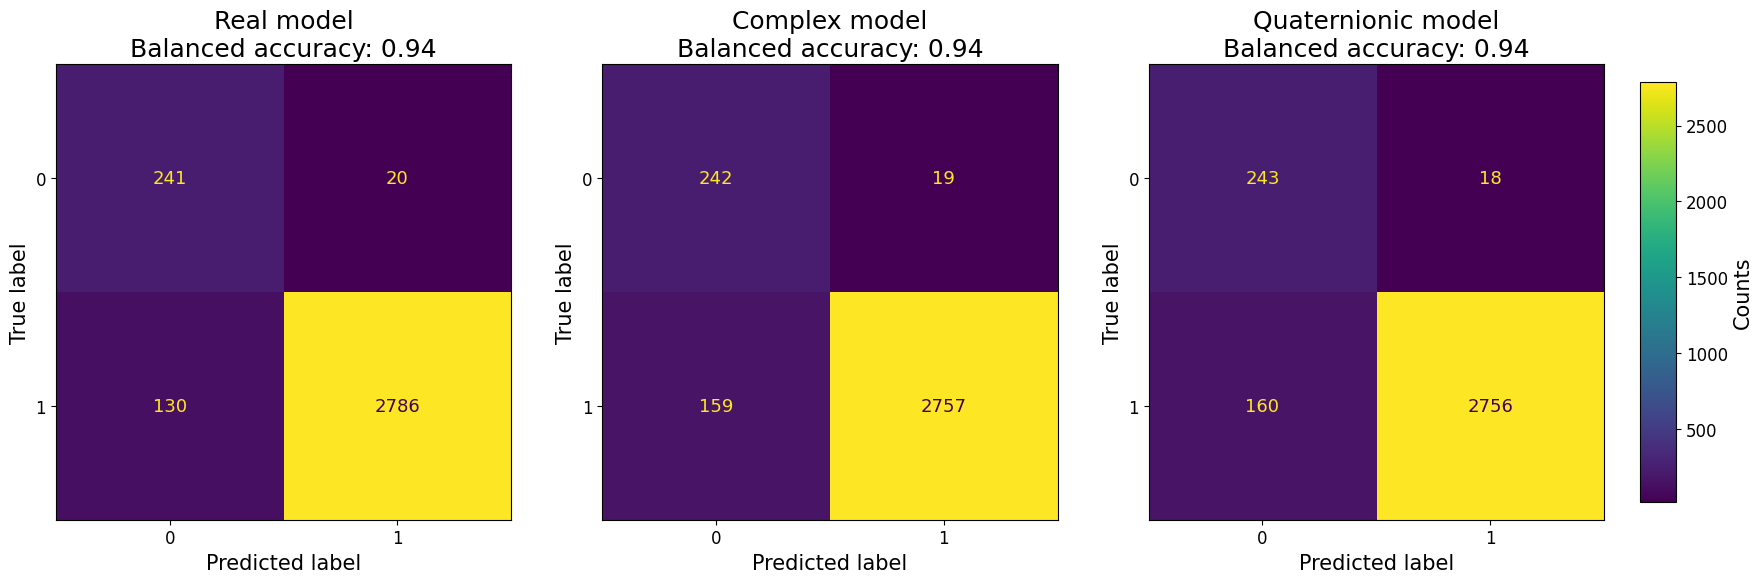

In [68]:

# Assuming model_C, model_R, model_Q, x_test_C, x_test_R, x_test_Q, y_test_C, y_test_R, y_test_Q are defined

# Predict and calculate balanced accuracy for model C
y_pred_C = np.argmax(model_C.predict(x_test_C), axis=1)
y_res_C = np.argmax(y_test_C, axis=1)
balanced_acc_C = balanced_accuracy_score(y_res_C, y_pred_C)

# Predict and calculate balanced accuracy for model R
y_pred_R = np.argmax(model_R.predict(x_test_R), axis=1)
y_res_R = np.argmax(y_test_R, axis=1)
balanced_acc_R = balanced_accuracy_score(y_res_R, y_pred_R)

# Predict and calculate balanced accuracy for model Q
y_pred_Q = np.argmax(model_Q.predict(x_test_Q), axis=1)
y_res_Q = np.argmax(y_test_Q, axis=1)
balanced_acc_Q = balanced_accuracy_score(y_res_Q, y_pred_Q)

# Generate confusion matrices
cm_C = confusion_matrix(y_res_C, y_pred_C)
cm_R = confusion_matrix(y_res_R, y_pred_R)
cm_Q = confusion_matrix(y_res_Q, y_pred_Q)

# Find the maximum value for normalization
max_value = max(cm_C.max(), cm_R.max(), cm_Q.max())

# Plot confusion matrices side by side with a shared color scale
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
cmap = plt.cm.viridis

# Plot for model R
disp_R = ConfusionMatrixDisplay(confusion_matrix=cm_R)
disp_R.plot(ax=axes[0], cmap=cmap, colorbar=False)
axes[0].set_title(f'Real model\nBalanced accuracy: {balanced_acc_R:.2f}')
axes[0].set_xlabel('Predicted label')
axes[0].set_ylabel('True label')

# Plot for model C
disp_C = ConfusionMatrixDisplay(confusion_matrix=cm_C)
disp_C.plot(ax=axes[1], cmap=cmap, colorbar=False)
axes[1].set_title(f'Complex model\nBalanced accuracy: {balanced_acc_C:.2f}')
axes[1].set_xlabel('Predicted label')
axes[1].set_ylabel('True label')

# Plot for model Q
disp_Q = ConfusionMatrixDisplay(confusion_matrix=cm_Q)
disp_Q.plot(ax=axes[2], cmap=cmap, colorbar=False)
axes[2].set_title(f'Quaternionic model\nBalanced accuracy: {balanced_acc_Q:.2f}')
axes[2].set_xlabel('Predicted label')
axes[2].set_ylabel('True label')

# Adjust font sizes
for ax in axes:
    ax.title.set_fontsize(18)
    ax.xaxis.label.set_fontsize(15)
    ax.yaxis.label.set_fontsize(15)
    ax.tick_params(axis='both', which='major', labelsize=12)

for ax in axes:
    for text in ax.texts:
        text.set_fontsize(13)

# Create an axis for the colorbar
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(axes[0].images[0], cax=cbar_ax)
cbar.set_label('Counts', fontsize=15)
cbar.ax.tick_params(labelsize=12)

# Adjust subplots to make space for the color bar and bring plots closer together
fig.subplots_adjust(left=0.05, right=0.91, top=0.9, bottom=0.1, wspace=0.2)

plt.show()
